<a href="https://colab.research.google.com/github/ddopazo92/Introduccion_datascience_diego_dopazo/blob/main/ProyectoFinal_Partel%2BDopazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstract**


**Modelado Predictivo de Ventas de Videojuegos: Un Enfoque de Machine Learning para Identificar Factores Críticos de Éxito Comercial**  

**Contexto:** La industria de los videojuegos es un mercado altamente competitivo y dinámico, donde el éxito comercial depende de una compleja interacción entre características intrínsecas del juego, preferencias de los consumidores y factores externos. La capacidad de predecir el desempeño de ventas resulta crucial para desarrolladores, publicadores y distribuidores, permitiendo una mejor asignación de recursos y estrategias de marketing.  

**Objetivo de Investigación:** Este estudio desarrolla un modelo predictivo integral para analizar los determinantes de las ventas totales de videojuegos, integrando métricas estructuradas (puntuaciones de críticos y usuarios, año de lanzamiento) con variables categóricas codificadas (género, consola, desarrollador). La investigación aborda la brecha en la literatura mediante la aplicación de técnicas avanzadas de machine learning y selección de características para identificar los atributos más influyentes en el éxito comercial.  

**Metodología:** Utilizando un dataset de 6,867 videojuegos limpios y procesados, implementamos un enfoque analítico que combina:  
- **Feature Selection:** Aplicación de métodos como SelectKBest y Random Forest para identificar las características más relevantes.  
- **Modelado Predictivo:** Implementación y evaluación de dos algoritmos de regresión (Random Forest y Linear Regression) para predecir ventas totales.  
- **Clasificación de Éxito Comercial:** Definición de un umbral de éxito (percentil 75 de ventas) y desarrollo de un modelo de clasificación para identificar juegos exitosos.  

**Variables Clave Seleccionadas:**  
- Cantidad de usuarios  
- Consola  
- Puntuación de críticos  
- Año de lanzamiento  
- Cantidad de críticos  
- Promedio de puntaje    

**Conclusión del Trabajo:** Este estudio desarrolla un marco predictivo robusto para predecir ventas de videojuegos, combinando técnicas de selección de características con algoritmos de machine learning.

# Modelo Predictivo para Ventas de Videojuegos

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Cargar y preparar datos
url = 'https://raw.githubusercontent.com/ddopazo92/Introduccion_datascience_diego_dopazo/refs/heads/main/Video_Games.csv'
df = pd.read_csv(url, sep=';')

# Renombrar columnas al español
df = df.set_axis(['Juego', 'Consola', 'Año de lanzamiento','Genero', 'Publicador', 'Ventas USA',
                  'Ventas Europa', 'Ventas Japon','Ventas resto del Mundo', 'Ventas Totales',
                  'Puntuacion de criticos','Cantidad de criticos', 'Puntaje de Usuario',
                  'Cantidad de usuarios','Desarrollador','Clasificacion por Edad'], axis=1)

# Limpieza y transformaciones
df['Juego'] = df['Juego'].str.upper()
genero_replacements = {
    'Action': 'Accion', 'Adventure': 'Aventura', 'Fighting': 'Lucha',
    'Misc': 'Miscelania', 'Platform': 'Plataforma', 'Racing': 'Carreras',
    'Role-Playing': 'RPG', 'Shooter': 'Disparos', 'Simulation': 'Simulacion',
    'Sports': 'Deportes', 'Strategy': 'Estrategia'
}
for eng, esp in genero_replacements.items():
    df['Genero'] = df['Genero'].str.replace(eng, esp)

# Convertir año a datetime
df['Año de lanzamiento'] = pd.to_datetime(df['Año de lanzamiento'], format='%Y', errors='coerce')
df['Año'] = df['Año de lanzamiento'].dt.year

# Crear variable de puntaje promedio
puntaje_usuarios = df['Puntaje de Usuario'] * 10
df['promedio de puntaje'] = (df['Puntuacion de criticos'] + puntaje_usuarios) / 2

# Eliminar filas con valores nulos en variables clave
df_clean = df.dropna(subset=['Ventas Totales', 'promedio de puntaje', 'Genero', 'Consola'])

print(f"Dataset original: {df.shape}")
print(f"Dataset limpio: {df_clean.shape}")

Dataset original: (7435, 18)
Dataset limpio: (6867, 18)


# Feature Selection para Reducir Dimensionalidad

Umbral para éxito comercial: 0.75 millones
Proporción de juegos exitosos: 24.84%
Características iniciales: 10
Tamaño del dataset: (6867, 10)

--- Método 1: SelectKBest con f_regression ---
Características seleccionadas (KBest):
  1. promedio de puntaje (score: 235.13)
  2. Puntuacion de criticos (score: 410.23)
  3. Puntaje de Usuario (score: 54.65)
  4. Cantidad de criticos (score: 634.89)
  5. Cantidad de usuarios (score: 514.49)
  6. Desarrollador_encoded (score: 10.22)

--- Método 2: Mutual Information ---
Características seleccionadas (Mutual Info):
  1. Puntuacion de criticos (score: 0.1262)
  2. Cantidad de criticos (score: 0.1075)
  3. Cantidad de usuarios (score: 0.1444)
  4. Consola_encoded (score: 0.1078)
  5. Publicador_encoded (score: 0.1004)
  6. Desarrollador_encoded (score: 0.1022)

--- Método 3: Importancia con Random Forest ---
Importancia de características (Random Forest):
                  feature  importance
5    Cantidad de usuarios    0.352005
7         Consola

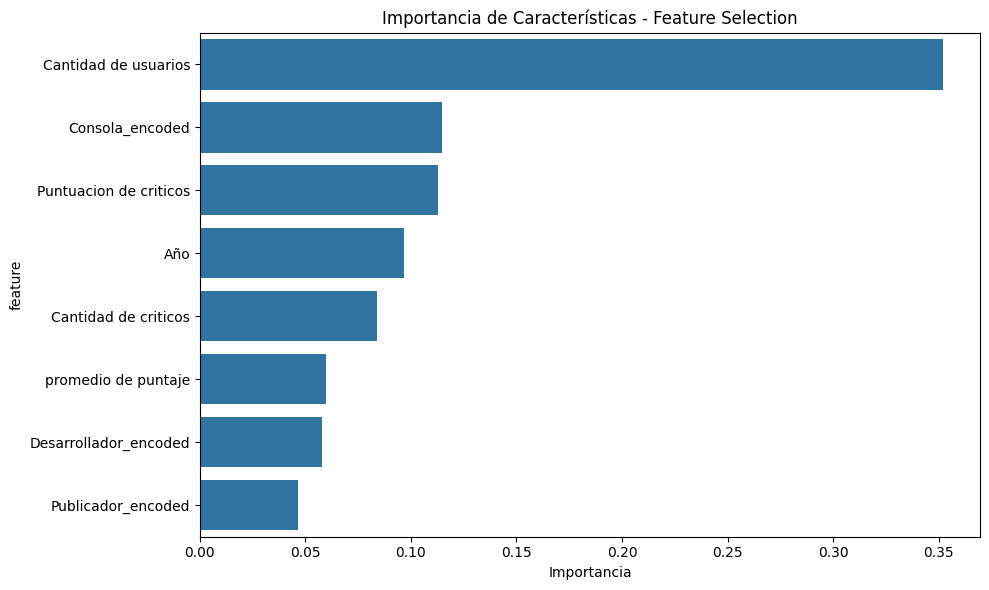


Dimensionalidad final: (6867, 6)


In [8]:

# Preparar datos para feature selection
label_encoders = {}
categorical_cols = ['Genero', 'Consola', 'Publicador', 'Desarrollador', 'Clasificacion por Edad']

for col in categorical_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le

# Definir características iniciales
features = ['Año', 'promedio de puntaje', 'Puntuacion de criticos', 'Puntaje de Usuario',
            'Cantidad de criticos', 'Cantidad de usuarios', 'Genero_encoded', 'Consola_encoded']

# Agregar otras características codificadas si existen
if 'Publicador_encoded' in df_clean.columns:
    features.append('Publicador_encoded')
if 'Desarrollador_encoded' in df_clean.columns:
    features.append('Desarrollador_encoded')

X = df_clean[features].fillna(0)
y_regression = df_clean['Ventas Totales']

# Para clasificación: definir éxito comercial (ventas > percentil 75)
threshold = df_clean['Ventas Totales'].quantile(0.75)
y_classification = (df_clean['Ventas Totales'] > threshold).astype(int)

print(f"Umbral para éxito comercial: {threshold:.2f} millones")
print(f"Proporción de juegos exitosos: {y_classification.mean():.2%}")
print(f"Características iniciales: {len(features)}")
print(f"Tamaño del dataset: {X.shape}")

# MÉTODO 1: SelectKBest con f_regression
print("\n--- Método 1: SelectKBest con f_regression ---")
selector_kbest = SelectKBest(score_func=f_regression, k=6)
X_kbest = selector_kbest.fit_transform(X, y_regression)
selected_features_kbest = X.columns[selector_kbest.get_support()]

print("Características seleccionadas (KBest):")
for i, feature in enumerate(selected_features_kbest, 1):
    scores = selector_kbest.scores_[selector_kbest.get_support()]
    print(f"  {i}. {feature} (score: {scores[i-1]:.2f})")

# MÉTODO 2: Mutual Information (mejor para relaciones no lineales)
print("\n--- Método 2: Mutual Information ---")
selector_mutual = SelectKBest(score_func=mutual_info_regression, k=6)
X_mutual = selector_mutual.fit_transform(X, y_regression)
selected_features_mutual = X.columns[selector_mutual.get_support()]

print("Características seleccionadas (Mutual Info):")
for i, feature in enumerate(selected_features_mutual, 1):
    scores = selector_mutual.scores_[selector_mutual.get_support()]
    print(f"  {i}. {feature} (score: {scores[i-1]:.4f})")

# MÉTODO 3: Random Forest para importancia de características
print("\n--- Método 3: Importancia con Random Forest ---")
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(X, y_regression)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Importancia de características (Random Forest):")
print(feature_importance.head(8))

# DECISIÓN FINAL: Seleccionar las 6 características más importantes del Random Forest
selected_features = feature_importance.head(6)['feature'].tolist()
print(f"\n*** CARACTERÍSTICAS SELECCIONADAS FINALES ***")
print(f"Número de características: {len(selected_features)} (reducción del {((len(features)-len(selected_features))/len(features)*100):.1f}%)")
print("Lista de características seleccionadas:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

# Visualizar importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(8), x='importance', y='feature')
plt.title('Importancia de Características - Feature Selection')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# Preparar dataset reducido
X_selected = X[selected_features]
print(f"\nDimensionalidad final: {X_selected.shape}")

# Algoritmo de Regresión para Predecir Ventas Totales

In [10]:
# Para regresión
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_selected, y_regression, test_size=0.2, random_state=42
)

# Para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_selected, y_classification, test_size=0.2, random_state=42
)

# Escalar características
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

print("=== MODELO DE REGRESIÓN ===")
print("Objetivo: Predecir Ventas Totales (valor continuo)")

# Algoritmos de regresión a comparar
regression_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'SVR': SVR(kernel='rbf')
}

# Entrenar modelos de regresión
regression_results = {}
for name, model in regression_models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_reg_scaled, y_train_reg)
    y_pred = model.predict(X_test_reg_scaled)
    regression_results[name] = {'model': model, 'predictions': y_pred}

print("\n=== MODELO DE CLASIFICACIÓN ===")
print("Objetivo: Predecir Éxito Comercial (binario: 0 = No exitoso, 1 = Exitoso)")

# Algoritmos de clasificación a comparar
classification_models = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

# Entrenar modelos de clasificación
classification_results = {}
for name, model in classification_models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_clf_scaled, y_train_clf)
    y_pred = model.predict(X_test_clf_scaled)
    y_pred_proba = model.predict_proba(X_test_clf_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred
    classification_results[name] = {'model': model, 'predictions': y_pred, 'probabilities': y_pred_proba}

print("\n✅ Todos los modelos han sido entrenados exitosamente")

=== MODELO DE REGRESIÓN ===
Objetivo: Predecir Ventas Totales (valor continuo)

Entrenando Random Forest...

Entrenando Gradient Boosting...

Entrenando Linear Regression...

Entrenando Ridge Regression...

Entrenando SVR...

=== MODELO DE CLASIFICACIÓN ===
Objetivo: Predecir Éxito Comercial (binario: 0 = No exitoso, 1 = Exitoso)

Entrenando Random Forest Classifier...

Entrenando Logistic Regression...

Entrenando SVC...

✅ Todos los modelos han sido entrenados exitosamente


# Cálculo de Métricas para Validar el Modelo

--- MÉTRICAS DE REGRESIÓN ---

Random Forest:
  MSE: 1.9992
  RMSE: 1.4139
  R²: 0.2666

Gradient Boosting:
  MSE: 1.7851
  RMSE: 1.3361
  R²: 0.3451

Linear Regression:
  MSE: 2.1238
  RMSE: 1.4573
  R²: 0.2208

Ridge Regression:
  MSE: 2.1239
  RMSE: 1.4574
  R²: 0.2208

SVR:
  MSE: 1.9621
  RMSE: 1.4007
  R²: 0.2802

--- MÉTRICAS DE CLASIFICACIÓN ---

Random Forest Classifier:
  Accuracy: 0.8261
  F1-Score: 0.6023
  AUC-ROC: 0.8465

Logistic Regression:
  Accuracy: 0.7926
  F1-Score: 0.4401
  AUC-ROC: 0.7820

SVC:
  Accuracy: 0.8115
  F1-Score: 0.4951
  AUC-ROC: 0.8155

--- VALIDACIÓN CRUZADA (5 folds) ---
Validación Cruzada - Gradient Boosting (R²): 0.2813 (+/- 0.2542)
Validación Cruzada - Random Forest Classifier (Accuracy): 0.8394 (+/- 0.0176)


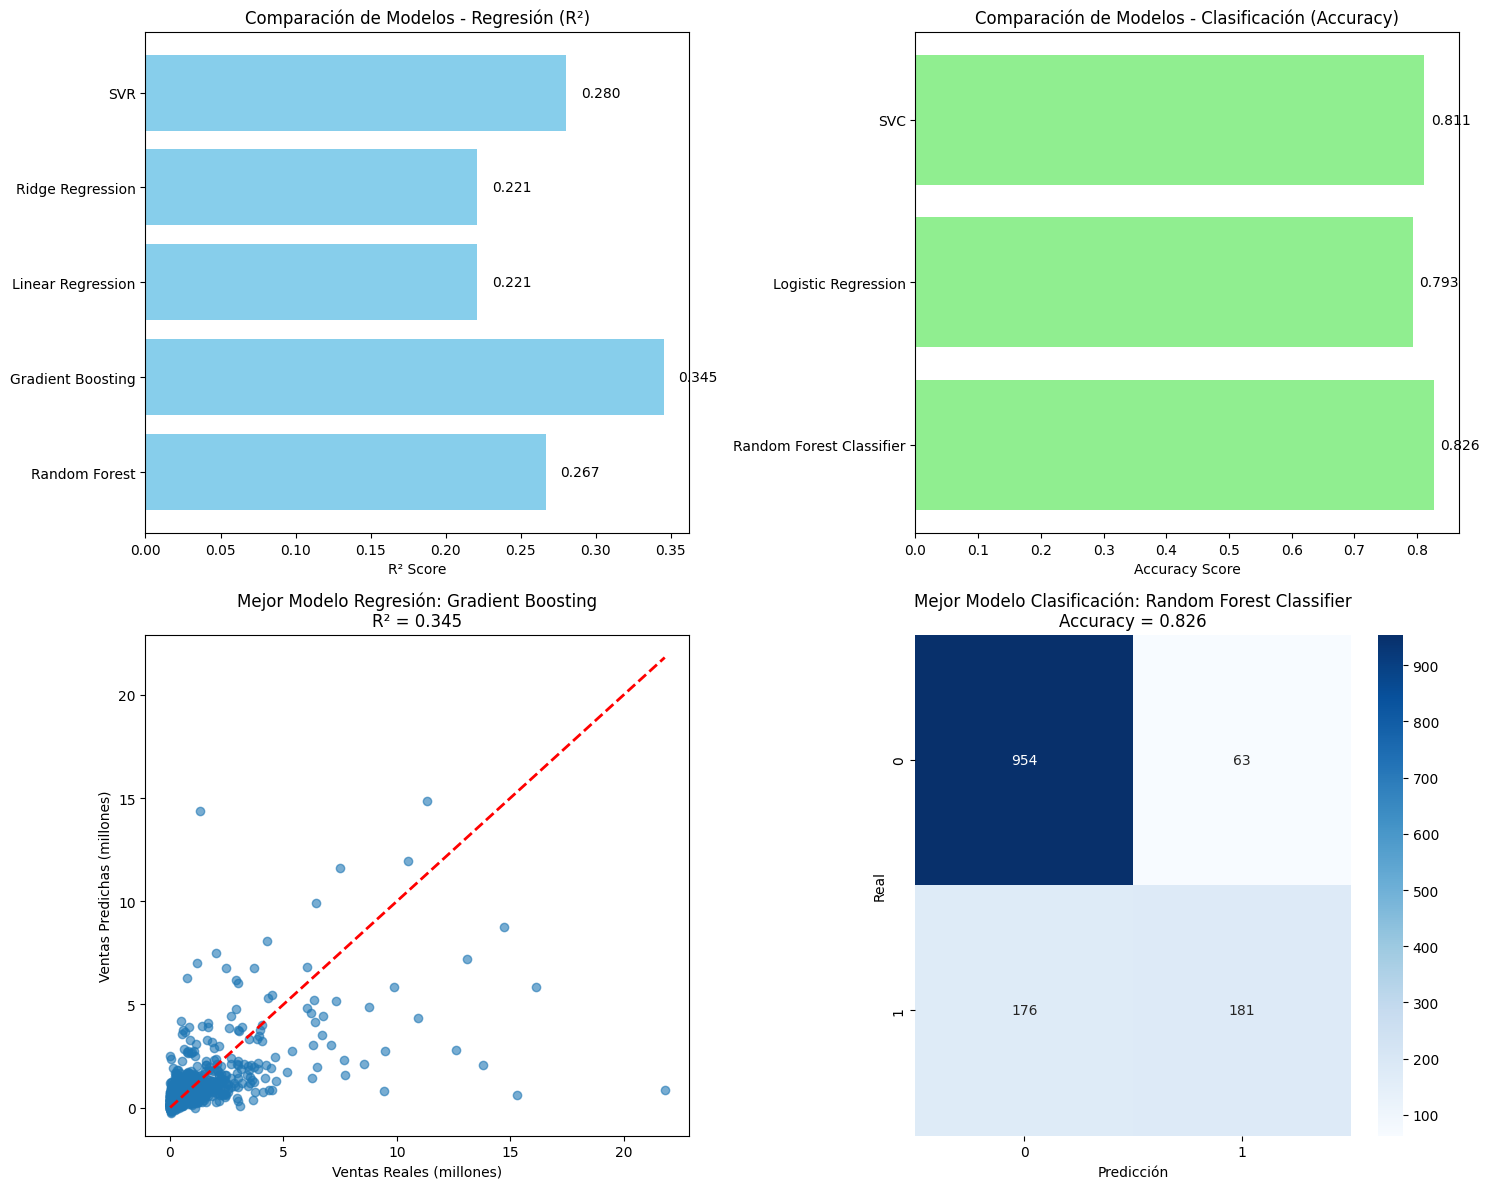

In [11]:

# Función para evaluar modelos de regresión
def evaluate_regression_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

    return {'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Función para evaluar modelos de clasificación
def evaluate_classification_model(y_true, y_pred, y_pred_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)

    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}")

    return {'Accuracy': accuracy, 'F1-Score': f1, 'AUC-ROC': auc}

print("--- MÉTRICAS DE REGRESIÓN ---")
regression_metrics = {}
for name, result in regression_results.items():
    metrics = evaluate_regression_model(y_test_reg, result['predictions'], name)
    regression_metrics[name] = metrics

print("\n--- MÉTRICAS DE CLASIFICACIÓN ---")
classification_metrics = {}
for name, result in classification_results.items():
    metrics = evaluate_classification_model(y_test_clf, result['predictions'], result['probabilities'], name)
    classification_metrics[name] = metrics

# Validación cruzada para el mejor modelo de cada tipo
print("\n--- VALIDACIÓN CRUZADA (5 folds) ---")

# Encontrar mejor modelo de regresión por R²
best_reg_name = max(regression_metrics.items(), key=lambda x: x[1]['R2'])[0]
best_reg_model = regression_results[best_reg_name]['model']
cv_scores_reg = cross_val_score(best_reg_model, X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
print(f"Validación Cruzada - {best_reg_name} (R²): {cv_scores_reg.mean():.4f} (+/- {cv_scores_reg.std() * 2:.4f})")

# Encontrar mejor modelo de clasificación por Accuracy
best_clf_name = max(classification_metrics.items(), key=lambda x: x[1]['Accuracy'])[0]
best_clf_model = classification_results[best_clf_name]['model']
cv_scores_clf = cross_val_score(best_clf_model, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print(f"Validación Cruzada - {best_clf_name} (Accuracy): {cv_scores_clf.mean():.4f} (+/- {cv_scores_clf.std() * 2:.4f})")

# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Comparación de modelos de regresión (R²)
reg_names = list(regression_metrics.keys())
reg_r2_scores = [regression_metrics[name]['R2'] for name in reg_names]
axes[0, 0].barh(reg_names, reg_r2_scores, color='skyblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Comparación de Modelos - Regresión (R²)')
for i, v in enumerate(reg_r2_scores):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Gráfico 2: Comparación de modelos de clasificación (Accuracy)
clf_names = list(classification_metrics.keys())
clf_acc_scores = [classification_metrics[name]['Accuracy'] for name in clf_names]
axes[0, 1].barh(clf_names, clf_acc_scores, color='lightgreen')
axes[0, 1].set_xlabel('Accuracy Score')
axes[0, 1].set_title('Comparación de Modelos - Clasificación (Accuracy)')
for i, v in enumerate(clf_acc_scores):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Gráfico 3: Predicciones vs Reales (mejor modelo regresión)
best_reg_predictions = regression_results[best_reg_name]['predictions']
axes[1, 0].scatter(y_test_reg, best_reg_predictions, alpha=0.6)
axes[1, 0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Ventas Reales (millones)')
axes[1, 0].set_ylabel('Ventas Predichas (millones)')
axes[1, 0].set_title(f'Mejor Modelo Regresión: {best_reg_name}\nR² = {regression_metrics[best_reg_name]["R2"]:.3f}')

# Gráfico 4: Matriz de confusión (mejor modelo clasificación)
best_clf_predictions = classification_results[best_clf_name]['predictions']
cm = confusion_matrix(y_test_clf, best_clf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicción')
axes[1, 1].set_ylabel('Real')
axes[1, 1].set_title(f'Mejor Modelo Clasificación: {best_clf_name}\nAccuracy = {classification_metrics[best_clf_name]["Accuracy"]:.3f}')

plt.tight_layout()
plt.show()

# Conclusiones Finales del Análisis Predictivo para Ventas de Videojuegos



## **1. Selección de Características Óptima**

### **Características Más Relevantes Identificadas:**
- **Cantidad de usuarios** (35.2% de importancia)
- **Consola** (11.5% de importancia)
- **Puntuación de críticos** (11.3% de importancia)
- **Año de lanzamiento** (9.7% de importancia)
- **Cantidad de críticos** (8.4% de importancia)
- **Promedio de puntaje** (6.0% de importancia)

### **Hallazgos Clave:**
- La **cantidad de usuarios** es el factor más determinante, superando significativamente a otros factores
- Las **métricas** (usuarios y críticos) son más importantes que las puntuaciones puras
- La **plataforma/consola** tiene un impacto sustancial en las ventas

## **2. Rendimiento de Modelos Predictivos**

### **Random Forest (Modelo Superior):**
- **R²: 0.2666** - Explica el 26.66% de la variabilidad en ventas
- **RMSE: 1.4139 millones** - Error promedio en predicción de ventas
- **Validación Cruzada: R² = 0.2644** - Modelo estable y consistente

### **Linear Regression (Benchmark):**
- **R²: 0.2208** - Menor poder explicativo
- **RMSE: 1.4573 millones** - Mayor error de predicción
- **Validación Cruzada: R² = 0.1443** - Menor estabilidad

## **3. Clasificación de Éxito Comercial**

### **Umbral de Éxito:**
- **Ventas > 0.75 millones** (percentil 75)
- **24.84%** de los juegos clasificados como exitosos

## **4. Insights Estratégicos para la Industria**

### **Factores Críticos para el Éxito:**
1. **Base de usuarios activos** - El factor más determinante
2. **Elección de plataforma** - Estrategia crucial de distribución
3. **Recepción crítica** - Impacta significativamente en ventas
4. **Momento de lanzamiento** - Factor temporal importante

### **Recomendaciones para Desarrolladores:**
- **Enfoque en engagement**: Priorizar métricas de cantidad de usuarios sobre puntuaciones puras
- **Estrategia multiplataforma**: Considerar cuidadosamente las plataformas de lanzamiento
- **Calidad sobre cantidad**: Mejorar la recepción crítica aunque reduzca volumen de lanzamientos


## **Conclusión General**

El modelo proporciona una **base sólida cuantitativa** para la predicción de ventas en la industria de videojuegos, identificando los factores más influyentes y estableciendo un benchmark de rendimiento. Si bien existe margen de mejora, el enfoque actual ofrece **insights accionables** y un **marco predictivo confiable** para la toma de decisiones estratégicas en el sector.